# Part 2 - adding variables, HP optimization

Looking at basic ways to improve the model:
- Adding other predictive variables; sprint speed, park facts
- Hyperparameter optimization for trees

Load up data and packages again...

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('tjb')

from pybaseball import statcast
import numpy as np
np.random.seed(123) # for reproducibility 
pd.options.display.max_columns = 999
import os
import sys
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

# Locally defined things
module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/python/")
from helper_functions import scrub_stringers
from feature_builder import *

year = '2018'
saveDir = '../run/part2/'
refresh_data = False

STATIC_MAX_DEPTH = 12

In [2]:
if refresh_data:
    data = statcast(start_dt=year+'-03-29', end_dt=year+'-10-28')
    data.to_feather("../data/2018_data_raw.feather")    
else:
    data = pd.read_feather("../data/2018_data_raw.feather")

In [3]:
scrub_data = scrub_stringers(data)
targets = ["field_out", "single", "double",  "triple", "home_run"]
target_df = scrub_data[scrub_data['events'].isin(targets)]
target_df = add_spray_angle(target_df)

/Users/tburch/Documents/github/mlb-hit-classifier/python/feature_builder.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["spray_angle"] = np.arctan((df["hc_x"]-125.42)/(198.27-df["hc_y"]))*180/np.pi*.75
/Users/tburch/Documents/github/mlb-hit-classifier/python/feature_builder.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["adj_spray_angle"] = df.apply(lambda row: -row["spray_angle"] if row["stand"] == "L" else row["spray_angle"], axis=1)


## Setup data and define useful base functions

In [4]:
# BDT parameters
def generate_params(features, bdt_kwargdict={}, task_kwargdict={}):
    bdt_param={}
    bdt_param["learning_rate"] = 0.4
    bdt_param['max_depth']        = 3  # maximum depth of a tree
    bdt_param['subsample']        = 1.0 # fraction of events to train tree on
    bdt_param['colsample_bytree'] = 1.0 # fraction of features to train tree on
    bdt_param['objective']   = 'multi:softmax' # objective function
    bdt_param['n_estimators']   = 200 
    bdt_param['num_class'] = 5
    bdt_param['feature_names'] = features

    # Learning task parameters
    task_param={}
    task_param['eval_metric'] = ['mlogloss', 'merror']           # evaluation metric for cross validation
    task_param['early_stopping_rounds'] = 30
    task_param['eval_set'] = [(X_train, y_train), (X_test,y_test)]
   
    bdt_param.update(bdt_kwargdict)
    task_param.update(task_kwargdict)
    return bdt_param, task_param

### Add new features

Use functions defined in ```python/feature_builder.py```

In [5]:
target_df = add_park_factors(target_df, 2017)

In [6]:
target_df = add_sprint_speed(target_df, 2017)

In [7]:
all_feature_cols = ['launch_speed', 'launch_angle', 'spray_angle', '1b_park_factor','2b_park_factor','3b_park_factor','hr_park_factor','sprint_speed']
slim_df = target_df.loc[:, all_feature_cols+["events"]]
slim_df = slim_df.dropna()
mask = np.random.rand(len(slim_df)) < 0.50
train = slim_df[mask]
test = slim_df[~mask]

X_train = train.loc[:, all_feature_cols]
X_test = test.loc[:, all_feature_cols]

le = LabelEncoder()
le.fit(slim_df["events"])
y_train = le.transform(train["events"]) 
y_test = le.transform(test["events"])

### Define some general-purpose functions

Plotting confusion matrices, training models

In [8]:
def conf_matrix(true, pred, classnames):
    conf_mat = confusion_matrix(true, pred,classnames)
    conf_mat = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
    np.set_printoptions(precision=2)
    plt.tick_params(axis='both', which='major', labelsize=14)    
    plt.yticks(va="center")
    sns.heatmap(conf_mat, annot=True, cmap='Blues', xticklabels=classnames, yticklabels=classnames, annot_kws={"size": 14})

In [9]:
def train_bdt(X, y, features, bdt_kwargdict={}, task_kwargdict={}):
    this_X = X[features]
    bdt_kwargdict.update({"feature_names":features})
    task_kwargdict.update({'eval_set': [(X_train[features], y_train), (X_test[features],y_test)]})
    bdt_param, task_param = generate_params(features, bdt_kwargdict=bdt_kwargdict, task_kwargdict=task_kwargdict)
    bdt = xgb.XGBClassifier(**bdt_param)
    bdt.fit(this_X, y_train, verbose=False, **task_param)
    print(bdt)
    return bdt

## Replicate Old Results

Use new depth and XGBoost

In [10]:
original_features = ['launch_speed', 'launch_angle', 'spray_angle']

Sklearn

In [11]:
from sklearn.ensemble import GradientBoostingClassifier
gbdt = GradientBoostingClassifier()
gbdt.fit(X_train[original_features], y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

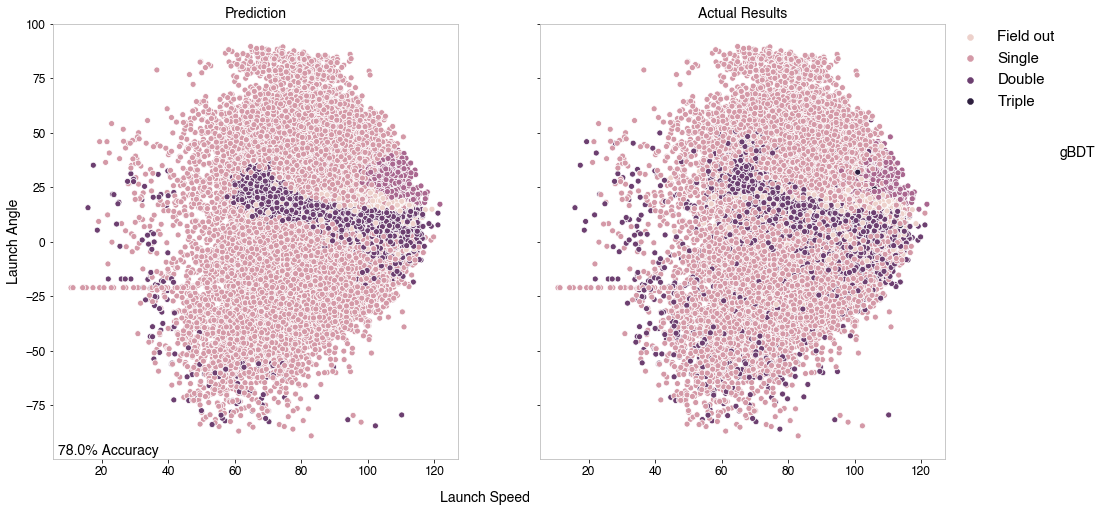

In [12]:
fig, ax_enum = plt.subplots(nrows=1, ncols=2, figsize=(16,8), sharey=True)
prediction_matrix = X_test.copy() 
prediction_matrix["prediction"] = gbdt.predict(X_test[original_features])
g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='prediction', 
           data=prediction_matrix,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[0])
plt.sca(ax_enum[0])
plt.ylabel("Launch Angle", fontsize=14)
plt.xlabel("", fontsize=14)
ax_enum[0].annotate("{0}% Accuracy".format(round(100*gbdt.score(X_test[original_features], y_test),1)),
                  xy=(0.013,0.01), xycoords="axes fraction", fontsize=14)
ax_enum[0].get_legend().remove()
plt.title("Prediction", fontsize=14)

prediction_matrix["truth"] = y_test
g = sns.scatterplot(x='launch_speed', y='launch_angle', hue='truth', 
           data=prediction_matrix,hue_order=targets, markers={"s": 10, "alpha" : 0.5}, ax=ax_enum[1])
plt.sca(ax_enum[1])
_=plt.title("Actual Results", fontsize=14)
plt.ylabel("", fontsize=14)
plt.xlabel("", fontsize=14)
#for ax in ax_enum:
#    ax.tick_params(axis='both', which='major', labelsize=12)

handles, labels = plt.gca().get_legend_handles_labels()
fixtargets = [t.replace("_"," ").capitalize() for t in targets]
plt.legend(handles=handles[1:],labels=fixtargets, bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., fontsize=15, frameon=False)

plt.figtext(s="gBDT",x=1.03, y=0.65, fontsize=14, ha="right")
_ = plt.figtext(s="Launch Speed",x=0.5, y=0.05, fontsize=14, ha="center")

Not exactly sure why the colors are different on this plot, strange, but carrying on...

In [13]:
original_bdt = train_bdt(X_train, y_train, original_features, bdt_kwargdict={"max_depth":STATIC_MAX_DEPTH, "feature_names":original_features})

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'spray_angle'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.4, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


In [14]:
original_bdt.score(X_test[original_features], y_test)

0.7779506890409674

## Park Effects

Add park effects by handedness to the model and see the effect

In [15]:
park_effects_features = ['launch_speed', 'launch_angle', 'spray_angle', '1b_park_factor','2b_park_factor','3b_park_factor','hr_park_factor']
park_effects_bdt = train_bdt(X_train, y_train, park_effects_features, bdt_kwargdict={"max_depth":STATIC_MAX_DEPTH})

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.4, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


In [16]:
park_effects_bdt.score(X_test[park_effects_features], y_test)

0.7821318083809881

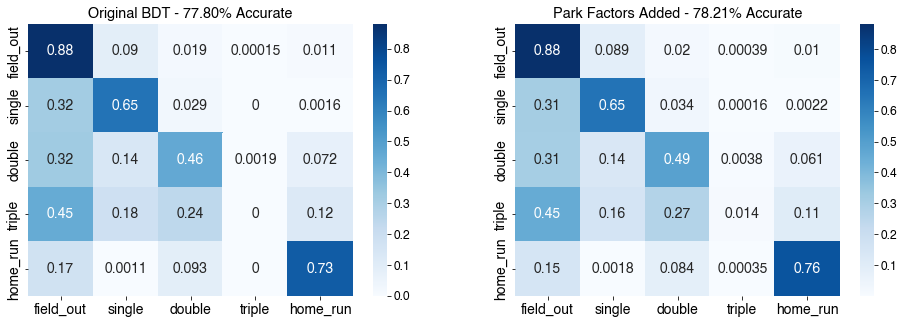

In [17]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(original_bdt.predict(X_test[original_features])), classnames=targets)
plt.title("Original BDT - {0:.2f}% Accurate".format(100*original_bdt.score(X_test[original_features], y_test)))
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(park_effects_bdt.predict(X_test[park_effects_features])), classnames=targets)
_=plt.title("Park Factors Added - {0:.2f}% Accurate".format(100*park_effects_bdt.score(X_test[park_effects_features], y_test)))
plt.savefig(saveDir+"/parkfactor_confusion", bbox_inches='tight')

Helps improve accuracy, especially for extra base hits. Check how many correct triples...

In [18]:
print(sum(park_effects_bdt.predict(X_test[park_effects_features][y_test==4])==4))
print(np.where((park_effects_bdt.predict(X_test[park_effects_features][y_test==4])==4)))

6
(array([ 90,  91, 127, 181, 227, 407]),)


In [19]:
print(sum(y_test==4))

432


6/432 triples, still not great.

## Sprint Speed

Add sprint speed to base model

In [20]:
sprint_features = ['launch_speed', 'launch_angle', 'spray_angle', 'sprint_speed']
sprint_bdt = train_bdt(X_train, y_train, sprint_features, bdt_kwargdict={"max_depth":STATIC_MAX_DEPTH})

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'spray_angle',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.4, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


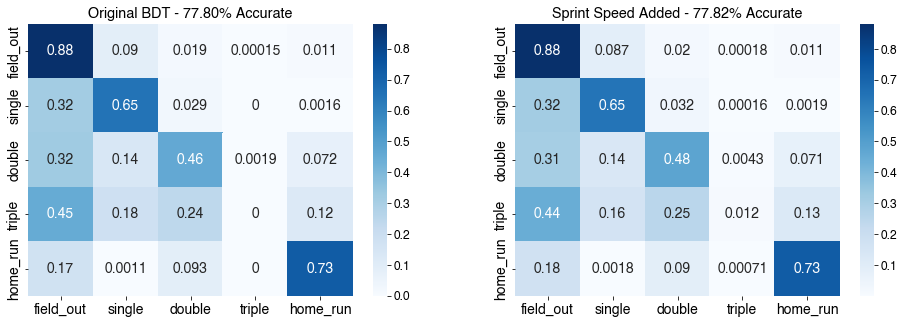

In [21]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(original_bdt.predict(X_test[original_features])), classnames=targets)
plt.title("Original BDT - {0:.2f}% Accurate".format(100*original_bdt.score(X_test[original_features], y_test)))
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(sprint_bdt.predict(X_test[sprint_features])), classnames=targets)
_=plt.title("Sprint Speed Added - {0:.2f}% Accurate".format(100*sprint_bdt.score(X_test[sprint_features], y_test)))
plt.savefig(saveDir+"/sprint_confusion", bbox_inches='tight')

Some improvement, but not a lot. Mostly in doubles and triples - makes sense, that's where speed matters most

In [22]:
print(sum(sprint_bdt.predict(X_test[sprint_features][y_test==4])==4))
print(np.where((sprint_bdt.predict(X_test[sprint_features][y_test==4])==4)))

5
(array([ 20,  90, 152, 258, 334]),)


5 correct triples, only 1 overlaps with the park factor set

## All new features combined

Both sprint speed and park effects to see combined effect

In [23]:
new_feature_bdt = train_bdt(X_train, y_train, all_feature_cols, bdt_kwargdict={"max_depth":STATIC_MAX_DEPTH})

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.4, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_class=5, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1.0, tree_method=None, validate_parameters=False,
              verbosity=None)


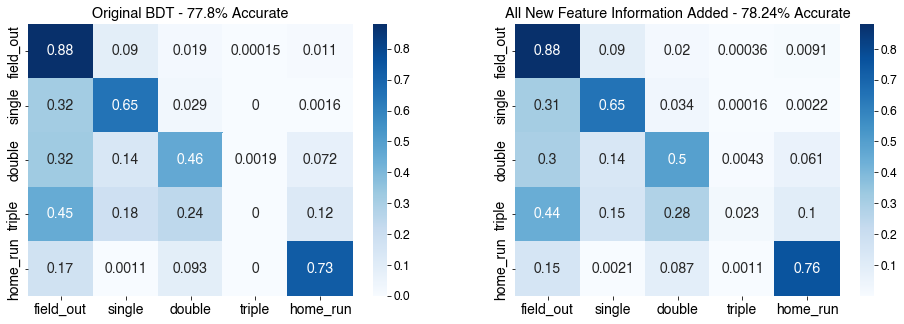

In [24]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(original_bdt.predict(X_test[original_features])), classnames=targets)
plt.title("Original BDT - {0}% Accurate".format(round(100*original_bdt.score(X_test[original_features], y_test),2)))
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(new_feature_bdt.predict(X_test[all_feature_cols])), classnames=targets)
_=plt.title("All New Feature Information Added - {0}% Accurate".format(round(100*new_feature_bdt.score(X_test[all_feature_cols], y_test),2)))
plt.savefig(saveDir+"/newfeature_confusion", bbox_inches='tight')

In [25]:
print(sum(new_feature_bdt.predict(X_test[all_feature_cols][y_test==4])==4))
np.where((new_feature_bdt.predict(X_test[all_feature_cols][y_test==4])==4))

(array([ 61,  90,  92, 127, 258, 277, 339, 368, 407, 420]),)

Most correct triples so far, still very small compared to number in dataset

## HP Optitimization

Start by just optimizing this model, look at key HPs: depth, learning rate

Vary both in a reasonable range, then make a summary plot

In [27]:
hitclass_bdt_param={}
hitclass_bdt_param['subsample']        = 1.0 # fraction of events to train tree on
hitclass_bdt_param['colsample_bytree'] = 1.0 # fraction of features to train tree on
hitclass_bdt_param['objective']   = "multi:softmax"
hitclass_bdt_param['n_estimators']   = 200 
hitclass_bdt_param['feature_names'] = all_feature_cols

# Learning task parameters
hitclass_task_param={}
hitclass_task_param['eval_metric'] = ['mlogloss', 'merror']           # evaluation metric for cross validation
hitclass_task_param['early_stopping_rounds'] = 30
hitclass_task_param['eval_set'] = [(X_train,y_train), (X_test,y_test)]


depth_scores_train=[]
depth_scores_test=[]
depths = [1, 2, 3, 5, 6, 7, 8, 9, 10]

for depth in depths:
    iparams={}
    hitclass_bdt_param["max_depth"] = depth
    i_opt_bdt =   xgb.XGBClassifier(**hitclass_bdt_param)
    i_opt_bdt.fit(X_train, y_train, verbose=False, **hitclass_task_param)
    
    depth_scores_train.append(i_opt_bdt.score(X_train,y_train))
    depth_scores_test.append(i_opt_bdt.score(X_test,y_test))
    print("Depth {0} completed. Accuracy - Train {1}, Test {2}".format(
        depth,
        depth_scores_train[-1],
        depth_scores_test[-1]
    ))

Depth 1 completed. Accuracy - Train 0.7374387947269303, Test 0.7320521233711447
Depth 2 completed. Accuracy - Train 0.7892843691148775, Test 0.780763101153089
Depth 3 completed. Accuracy - Train 0.8069114877589454, Test 0.7856191994000188
Depth 5 completed. Accuracy - Train 0.8270998116760828, Test 0.7877941314333927
Depth 6 completed. Accuracy - Train 0.8430696798493409, Test 0.7870254054560795
Depth 7 completed. Accuracy - Train 0.8366666666666667, Test 0.7874566419799381
Depth 8 completed. Accuracy - Train 0.8416949152542373, Test 0.7880191244023624
Depth 9 completed. Accuracy - Train 0.8763841807909605, Test 0.7872316490109684
Depth 10 completed. Accuracy - Train 0.8800941619585687, Test 0.7859379394393925


In [29]:
hitclass_bdt_param['max_depth']   = 5


eta_scores_train=[]
eta_scores_test=[]
eta_values = [0.05, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5]


for eta in eta_values:
    iparams={}
    hitclass_bdt_param["learning_rate"] = eta
    i_opt_bdt =   xgb.XGBClassifier(**hitclass_bdt_param)
    i_opt_bdt.fit(X_train, y_train, verbose=False, **hitclass_task_param)
    
    eta_scores_train.append(i_opt_bdt.score(X_train,y_train))
    eta_scores_test.append(i_opt_bdt.score(X_test,y_test))
    print("Learning rate {0} completed. Accuracy - Train {1}, Test {2}".format(
        eta,
        eta_scores_train[-1],
        eta_scores_test[-1]
    ))

Learning rate 0.05 completed. Accuracy - Train 0.802617702448211, Test 0.7857316958845036
Learning rate 0.1 completed. Accuracy - Train 0.8135969868173258, Test 0.7882816161994938
Learning rate 0.15 completed. Accuracy - Train 0.8229001883239171, Test 0.788150370300928
Learning rate 0.2 completed. Accuracy - Train 0.8331638418079096, Test 0.7874003937376957
Learning rate 0.3 completed. Accuracy - Train 0.8270998116760828, Test 0.7877941314333927
Learning rate 0.4 completed. Accuracy - Train 0.8189077212806026, Test 0.7868941595575139
Learning rate 0.5 completed. Accuracy - Train 0.8109604519774011, Test 0.7854504546732914


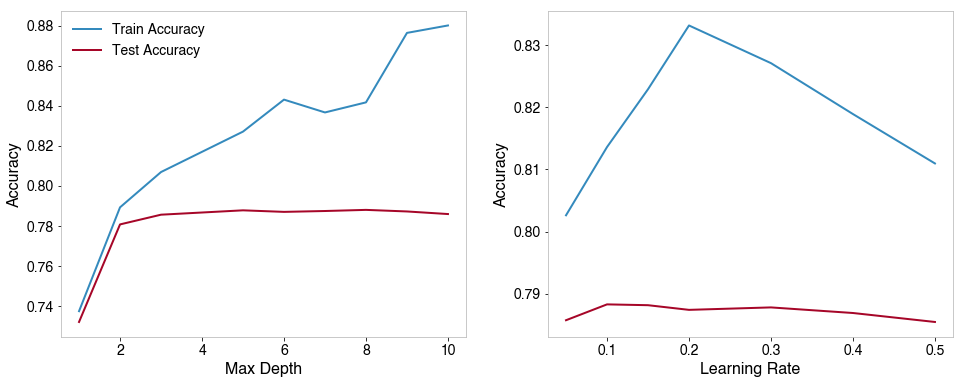

In [30]:
# Formal Joint plot
fig, ax_enum = plt.subplots(1,2, figsize=(16,6))
plt.sca(ax_enum[0])
plt.plot(depths, depth_scores_train, label="Train Accuracy")
plt.plot(depths, depth_scores_test, label="Test Accuracy")
plt.legend(frameon=False,fontsize=14)
plt.ylabel("Accuracy",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)
plt.tick_params(labelsize=14)

plt.sca(ax_enum[1])
plt.plot(eta_values, eta_scores_train, label="Train Accuracy")
plt.plot(eta_values, eta_scores_test, label="Test Accuracy")
plt.ylabel("Accuracy",fontsize=16)
plt.xlabel("Learning Rate",fontsize=16)
plt.tick_params(labelsize=14)

#_= plt.annotate("",xy=(.53,0.96), xycoords="figure fraction", ha="center", va="top", fontsize=20)
plt.savefig(saveDir+"real_HP_optimization", bbox_inches="tight")

Use depth of 5, learning rate 0.3.

XGBoost uses early stopping, but we should check to make sure that early stopping is invoked, not running out of trees

In [31]:
hitclass_bdt_param["max_depth"] = 5
hitclass_bdt_param["learning_rate"] = 0.3


ntree_scores_train=[]
ntree_scores_test=[]
ntree_values = [10, 20, 40, 60, 80, 100, 150, 200]


for ntree in ntree_values:
    iparams={}
    hitclass_bdt_param["n_estimators"] = ntree
    i_opt_bdt =   xgb.XGBClassifier(**hitclass_bdt_param)
    i_opt_bdt.fit(X_train, y_train, verbose=False, **hitclass_task_param)
    
    ntree_scores_train.append(i_opt_bdt.score(X_train,y_train))
    ntree_scores_test.append(i_opt_bdt.score(X_test,y_test))
    print("nTrees {0} completed. Accuracy - Train {1}, Test {2}".format(
        ntree,
        ntree_scores_train[-1],
        ntree_scores_test[-1]
    ))

nTrees 10 completed. Accuracy - Train 0.7815442561205274, Test 0.7736008249742196
nTrees 20 completed. Accuracy - Train 0.7958380414312618, Test 0.782731789631574
nTrees 40 completed. Accuracy - Train 0.8050094161958569, Test 0.7861066841661198
nTrees 60 completed. Accuracy - Train 0.8131450094161958, Test 0.7872503984250492
nTrees 80 completed. Accuracy - Train 0.8160075329566855, Test 0.7874566419799381
nTrees 100 completed. Accuracy - Train 0.8270998116760828, Test 0.7877941314333927
nTrees 150 completed. Accuracy - Train 0.8270998116760828, Test 0.7877941314333927
nTrees 200 completed. Accuracy - Train 0.8270998116760828, Test 0.7877941314333927


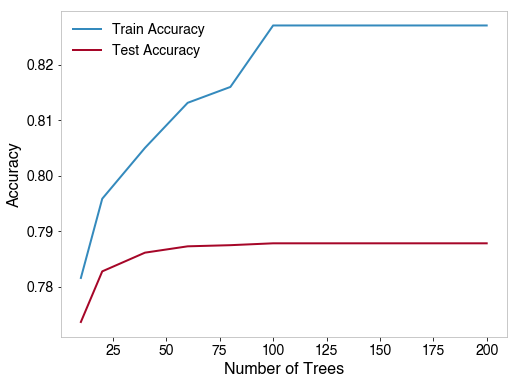

In [32]:
plt.figure(figsize=(8,6))
plt.plot(ntree_values, ntree_scores_train, label="Train Accuracy")
plt.plot(ntree_values, ntree_scores_test, label="Test Accuracy")
plt.legend(frameon=False,fontsize=14)
plt.ylabel("Accuracy",fontsize=16)
plt.xlabel("Number of Trees",fontsize=16)
plt.tick_params(labelsize=14)
plt.savefig(saveDir+"n_trees_opt", bbox_inches="tight")

Looks like we're good early on, flatted by 100

In [33]:
# Train Final Model
hitclass_bdt_param["max_depth"] = 5
hitclass_bdt_param["eta"] = 0.3
hitclass_bdt_param["n_estimators"] = 200
hitclass_task_param['early_stopping_rounds'] = 30

final_bdt =   xgb.XGBClassifier(**hitclass_bdt_param)
final_bdt.fit(X_train, y_train, verbose=True, **hitclass_task_param)


[0]	validation_0-mlogloss:1.24166	validation_0-merror:0.25812	validation_1-mlogloss:1.24629	validation_1-merror:0.26433
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.04438	validation_0-merror:0.24036	validation_1-mlogloss:1.05258	validation_1-merror:0.24762
[2]	validation_0-mlogloss:0.91173	validation_0-merror:0.23736	validation_1-mlogloss:0.92264	validation_1-merror:0.24385
[3]	validation_0-mlogloss:0.81955	validation_0-merror:0.23331	validation_1-mlogloss:0.83259	validation_1-merror:0.24046
[4]	validation_0-mlogloss:0.75434	validation_0-merror:0.23173	validation_1-mlogloss:0.76942	validation_1-merror:0.23883
[5]	validation_0-mlogloss:0.70632	validation_0-merror:0.22789	validation_1-mlogloss:0.72316	validation_1-merror:0.23521
[6]	validation_0-mlogloss:0.66984	validation_0-merror:0.22493	validation_1-mlogloss:0.68822	validation_1-merror:0.232

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, eta=0.3,
              feature_names=['launch_speed', 'launch_angle', 'spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.3, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)

Early stopping invoked at 127, using the 97th tree.

### Compare HP optimized model to unoptimized model with same parameters, and original model from previous post

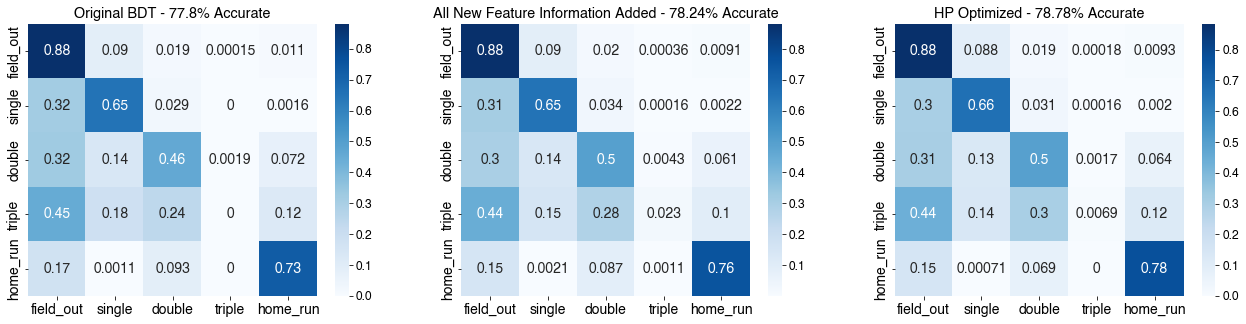

In [34]:
fig, ax_enum = plt.subplots(1,3, figsize=(22,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(original_bdt.predict(X_test[original_features])), classnames=targets)
plt.title("Original BDT - {0}% Accurate".format(round(100*original_bdt.score(X_test[original_features], y_test),2)))
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(new_feature_bdt.predict(X_test[all_feature_cols])), classnames=targets)
_=plt.title("All New Feature Information Added - {0}% Accurate".format(round(100*new_feature_bdt.score(X_test[all_feature_cols], y_test),2)))
plt.sca(ax_enum[2])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(final_bdt.predict(X_test[all_feature_cols])), classnames=targets)
_=plt.title("HP Optimized - {0}% Accurate".format(round(100*final_bdt.score(X_test[all_feature_cols], y_test),2)))
plt.savefig(saveDir+"/nfinal_confusion", bbox_inches='tight')

In [35]:
print(sum(final_bdt.predict(X_test[all_feature_cols][y_test==4])==4))
print(np.where((final_bdt.predict(X_test[all_feature_cols][y_test==4])==4)))

3
(array([ 90, 127, 339]),)


Unfortunately HP optimization has hurt triples, but better HR and single fidelity, which is better for overall accuracy since those classes are more populous

In [36]:
final_bdt.save_model('../models/hp_optimized')

Look at feature importance plots with final model to see what features are used most

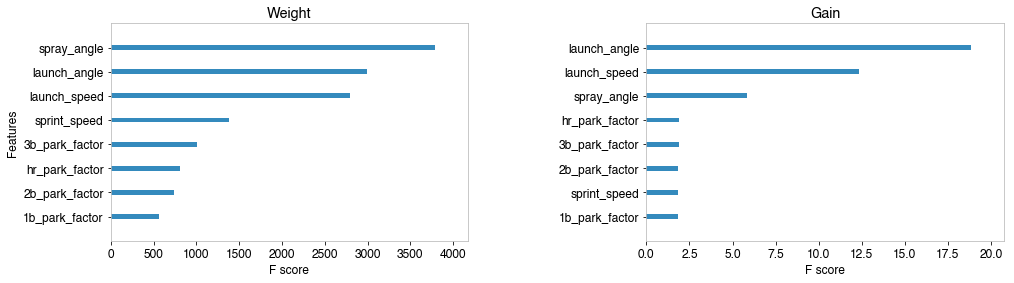

In [37]:
from xgboost import plot_importance
fig, ax_enum = plt.subplots(1,2, figsize=(16,4))
plot_importance(final_bdt, importance_type="weight", ax=ax_enum[0], title="Weight",show_values=False, grid=False)
plot_importance(final_bdt, importance_type="gain", ax=ax_enum[1], title="Gain", show_values=False, grid=False)
plt.ylabel("")
plt.sca(ax_enum[1])
plt.ylabel("")
plt.subplots_adjust(wspace=0.5)
plt.savefig(saveDir+"/hp_optimized_importance", bbox_inches='tight')

In [38]:
from pandas import HDFStore
import h5py

with HDFStore('../data/split_data.h5', mode="w") as store:
    store.put('X_train', X_train)
    store.put('X_test', X_test)
with h5py.File('../data/split_data.h5', mode="a") as f:
    f.create_dataset('y_train', data=y_train)
    f.create_dataset('y_test', data=y_test)

## Stacked Model (appendix in post)

Looking into an idea I had that breaks up the problem, possibly navigating the imbalance somewhat. Use binary classification for hit/not hit; then multiclassifier for hit type once it's a candidate to be a hit.

Need to evaluate which model is best for each step, starting with binary classifier

In [39]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [40]:
out_label = list(le.classes_).index("field_out")
hit_y_train = (y_train != out_label).astype(int)
hit_y_test = (y_test != out_label).astype(int)

In [41]:
kneighbors = KNeighborsClassifier()
kneighbors.fit(X_train[all_feature_cols], hit_y_train)
gbdt = GradientBoostingClassifier(max_depth=STATIC_MAX_DEPTH)
gbdt.fit(X_train[all_feature_cols], hit_y_train)
svc = SVC()
svc.fit(X_train[all_feature_cols], hit_y_train)
logistic = LogisticRegression(max_iter=500)
logistic.fit(X_train[all_feature_cols], hit_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=500,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [42]:
classifier = ["kNN", "SVC", "gBDT","Logistic\nRegression"]
scores = []
scores.append(kneighbors.score(X_test[all_feature_cols],hit_y_test))
scores.append(svc.score(X_test[all_feature_cols],hit_y_test))
scores.append(gbdt.score(X_test[all_feature_cols],hit_y_test))
scores.append(logistic.score(X_test[all_feature_cols],hit_y_test))

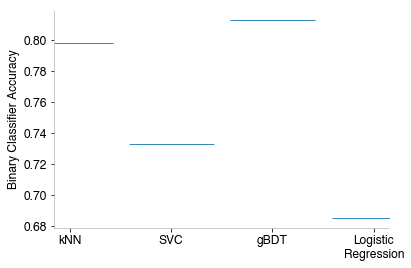

In [43]:
plt.plot(classifier, scores, marker='_', linewidth=0, markersize=85)
plt.ylabel("Binary Classifier Accuracy")
sns.despine()
plt.savefig(saveDir+"/binary_classifier_model_accuracy", bbox_inches='tight')

Looks like still the BDT is best, though kNN is close.

Next, look at multiclassifier

In [44]:
X_train_hitonly = X_train[hit_y_train.astype(bool)]
X_test_hitonly = X_test[hit_y_test.astype(bool)]
y_train_hitonly = y_train[hit_y_train.astype(bool)]
y_test_hitonly = y_test[hit_y_test.astype(bool)]

In [45]:
kneighbors2 = KNeighborsClassifier()
kneighbors2.fit(X_train_hitonly[all_feature_cols], y_train_hitonly)
gbdt2 = GradientBoostingClassifier(max_depth=STATIC_MAX_DEPTH)
gbdt2.fit(X_train_hitonly[all_feature_cols], y_train_hitonly)
svc2 = SVC()
svc2.fit(X_train_hitonly[all_feature_cols], y_train_hitonly)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [46]:
classifier2 = ["kNN", "SVC", "gBDT"]
scores2 = []
scores2.append(kneighbors2.score(X_test_hitonly[all_feature_cols],y_test_hitonly))
scores2.append(svc2.score(X_test_hitonly[all_feature_cols],y_test_hitonly))
scores2.append(gbdt2.score(X_test_hitonly[all_feature_cols],y_test_hitonly))

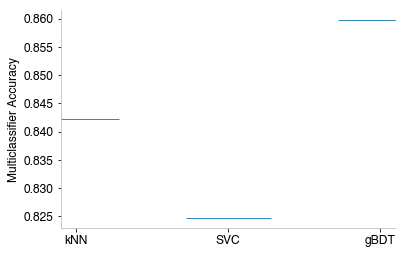

In [47]:
plt.plot(classifier2, scores2, marker='_', linewidth=0, markersize=85)
plt.ylabel("Multiclassifier Accuracy")
sns.despine()
plt.savefig(saveDir+"/multiclassifier_model_accuracy", bbox_inches='tight')

BDT is far better here. Using the same model for both steps generally means that one model will do better than splitting it up into steps, since there's information loss there.

Quickly put these two plots into one formal image....

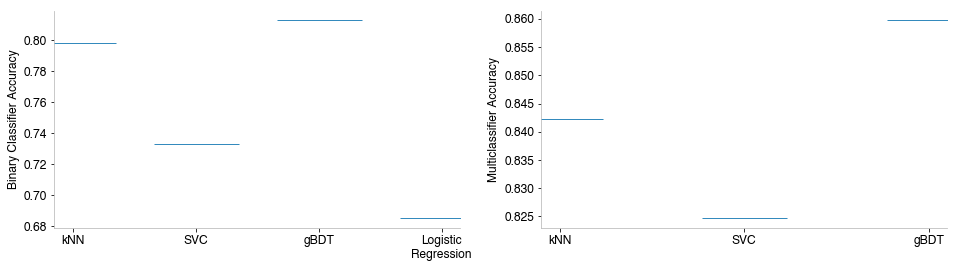

In [48]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,4))
plt.sca(ax_enum[0])
plt.plot(classifier, scores, marker='_', linewidth=0, markersize=85)
plt.ylabel("Binary Classifier Accuracy")
sns.despine()
plt.sca(ax_enum[1])
plt.plot(classifier2, scores2, marker='_', linewidth=0, markersize=85)
plt.ylabel("Multiclassifier Accuracy")
sns.despine()
plt.savefig(saveDir+"/two_model_accuracy", bbox_inches='tight')

Train full model for both steps....

In [49]:
binary_bdt_param={}
binary_bdt_param['learning_rate']      = 0.1 # learning rate
binary_bdt_param["max_depth"] =  STATIC_MAX_DEPTH
binary_bdt_param['subsample']        = 1.0 # fraction of events to train tree on
binary_bdt_param['colsample_bytree'] = 1.0 # fraction of features to train tree on
binary_bdt_param['objective'] = "binary:logistic"
binary_bdt_param['n_estimators']   = 200 
binary_bdt_param['feature_names'] = all_feature_cols

# Learning task parameters
binary_task_param={}
binary_task_param['eval_metric'] = ['logloss', 'error']           # evaluation metric for cross validation
binary_task_param['early_stopping_rounds'] = 30
binary_task_param['eval_set'] = [(X_train[all_feature_cols],hit_y_train), (X_test[all_feature_cols],hit_y_test)]


binary_bdt = xgb.XGBClassifier(**binary_bdt_param)
binary_bdt.fit(X_train[all_feature_cols], hit_y_train,verbose=False, **binary_task_param)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)

In [50]:
hitclass_bdt_param={}
hitclass_bdt_param['learning_rate']      = 0.1 # learning rate
hitclass_bdt_param["max_depth"] =  STATIC_MAX_DEPTH
hitclass_bdt_param['subsample']        = 1.0 # fraction of events to train tree on
hitclass_bdt_param['colsample_bytree'] = 1.0 # fraction of features to train tree on
hitclass_bdt_param['objective']   = "multi:softmax"
hitclass_bdt_param['n_estimators']   = 200 
hitclass_bdt_param['feature_names'] = all_feature_cols

# Learning task parameters
hitclass_task_param={}
hitclass_task_param['eval_metric'] = ['mlogloss', 'merror']           # evaluation metric for cross validation
hitclass_task_param['early_stopping_rounds'] = 30
hitclass_task_param['eval_set'] = [(X_train_hitonly[all_feature_cols],y_train_hitonly), (X_test_hitonly[all_feature_cols],y_test_hitonly)]


hitclass_bdt = xgb.XGBClassifier(**hitclass_bdt_param)
hitclass_bdt.fit(X_train_hitonly[all_feature_cols],y_train_hitonly, verbose=False, **hitclass_task_param)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.1, max_delta_step=0,
              max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)

In [51]:
hitclass_bdt = xgb.XGBClassifier(**{"objective":"multi:softmax", "max_depth": STATIC_MAX_DEPTH, "num_class":5})
print(hitclass_bdt)
hitclass_bdt.fit(X_train_hitonly[all_feature_cols], y_train_hitonly)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=12,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=5,
              num_parallel_tree=None, objective='multi:softmax',
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=False, verbosity=None)


XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints=None,
              learning_rate=0.300000012, max_delta_step=0, max_depth=12,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=0, num_class=5, num_parallel_tree=1,
              objective='multi:softprob', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method=None, validate_parameters=False, verbosity=None)

## HP Optimization for stacked model

We'll optimize both classifiers, as before

In [52]:
# Final sets:
final_X_train = X_train[all_feature_cols]
binary_y_train = hit_y_train

final_X_train_hitonly = X_train[all_feature_cols]
final_X_train_hitonly = final_X_train_hitonly[hit_y_train.astype(bool)]

final_X_test = X_test[all_feature_cols]
binary_y_test = hit_y_test

final_y_train = y_train
final_y_train_hitonly = final_y_train[hit_y_train.astype(bool)]

final_y_test = y_test

# Fix this
X_train_hitonly = X_train[hit_y_train.astype(bool)]
X_test_hitonly = X_test[hit_y_test.astype(bool)]
y_train_hitonly = y_train[hit_y_train.astype(bool)]
y_test_hitonly = y_test[hit_y_test.astype(bool)]

hit_x_train = X_train_hitonly[all_feature_cols]
hit_x_test = X_test_hitonly[all_feature_cols]

### Binary Classifier

In [53]:
hitclass_bdt_param={}
hitclass_bdt_param['learning_rate']      = 0.1 # learning rate
hitclass_bdt_param['subsample']        = 1.0 # fraction of events to train tree on
hitclass_bdt_param['colsample_bytree'] = 1.0 # fraction of features to train tree on
hitclass_bdt_param['n_estimators']   = 200 
hitclass_bdt_param['feature_names'] = all_feature_cols

# Learning task parameters
hitclass_task_param={}
hitclass_task_param['eval_metric'] = ['logloss', 'error']           # evaluation metric for cross validation
hitclass_task_param['early_stopping_rounds'] = 30
hitclass_task_param['eval_set'] = [(final_X_train,binary_y_train), (final_X_test,binary_y_test)]


depth_scores_train=[]
depth_scores_test=[]
depths = list(range(0,11))


for depth in depths:
    iparams={}
    hitclass_bdt_param["max_depth"] = depth
    i_opt_bdt =   xgb.XGBClassifier(**hitclass_bdt_param)
    i_opt_bdt.fit(final_X_train, binary_y_train, verbose=False, **hitclass_task_param)
    depth_scores_train.append(i_opt_bdt.score(final_X_train,binary_y_train))
    depth_scores_test.append(i_opt_bdt.score(final_X_test,binary_y_test))
    print("Depth {0} completed. Accuracy - Train {1:.4f}, Test {2:.4f}".format(
        depth,
        depth_scores_train[-1],
        depth_scores_test[-1]
    ))


Depth 0 completed. Accuracy - Train 0.6231, Test 0.6212
Depth 1 completed. Accuracy - Train 0.7637, Test 0.7601
Depth 2 completed. Accuracy - Train 0.7892, Test 0.7851
Depth 3 completed. Accuracy - Train 0.8073, Test 0.8015
Depth 4 completed. Accuracy - Train 0.8216, Test 0.8104
Depth 5 completed. Accuracy - Train 0.8358, Test 0.8180
Depth 6 completed. Accuracy - Train 0.8450, Test 0.8194
Depth 7 completed. Accuracy - Train 0.8436, Test 0.8183
Depth 8 completed. Accuracy - Train 0.8677, Test 0.8208
Depth 9 completed. Accuracy - Train 0.8820, Test 0.8212
Depth 10 completed. Accuracy - Train 0.9082, Test 0.8200


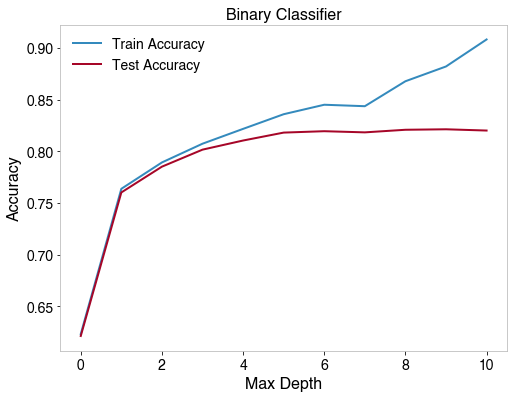

In [54]:
plt.figure(figsize=(8,6))
plt.plot(depths, depth_scores_train, label="Train Accuracy")
plt.plot(depths, depth_scores_test, label="Test Accuracy")
plt.legend(frameon=False,fontsize=14)
plt.ylabel("Accuracy",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)
plt.title("Binary Classifier",fontsize=16)
plt.tick_params(labelsize=14)
plt.savefig(saveDir+"binary_max_depth_optimization", bbox_inches="tight")

In [55]:
hitclass_bdt_param['max_depth']   = 6


eta_scores_train=[]
eta_scores_test=[]
eta_values = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]


for eta in eta_values:
    iparams={}
    hitclass_bdt_param["learning_rate"] = eta
    i_opt_bdt =   xgb.XGBClassifier(**hitclass_bdt_param)
    i_opt_bdt.fit(final_X_train, binary_y_train, verbose=False, **hitclass_task_param)
    
    eta_scores_train.append(i_opt_bdt.score(final_X_train,binary_y_train))
    eta_scores_test.append(i_opt_bdt.score(final_X_test,binary_y_test))
    print("Learning rate {0} completed. Accuracy - Train {1:.4f}, Test {2:.4f}".format(
        eta,
        eta_scores_train[-1],
        eta_scores_test[-1]
    ))

Learning rate 0.05 completed. Accuracy - Train 0.8343, Test 0.8163
Learning rate 0.1 completed. Accuracy - Train 0.8450, Test 0.8194
Learning rate 0.15 completed. Accuracy - Train 0.8498, Test 0.8203
Learning rate 0.2 completed. Accuracy - Train 0.8502, Test 0.8200
Learning rate 0.3 completed. Accuracy - Train 0.8570, Test 0.8198
Learning rate 0.5 completed. Accuracy - Train 0.8478, Test 0.8184


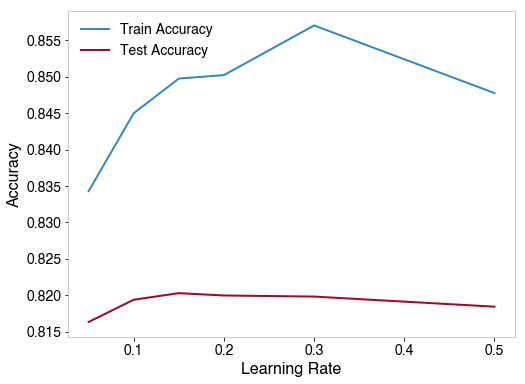

In [56]:
plt.figure(figsize=(8,6))
plt.plot(eta_values, eta_scores_train, label="Train Accuracy")
plt.plot(eta_values, eta_scores_test, label="Test Accuracy")
plt.legend(frameon=False,fontsize=14)
plt.ylabel("Accuracy",fontsize=16)
plt.xlabel("Learning Rate",fontsize=16)
plt.tick_params(labelsize=14)
plt.savefig(saveDir+"binary_eta_optimization", bbox_inches="tight")

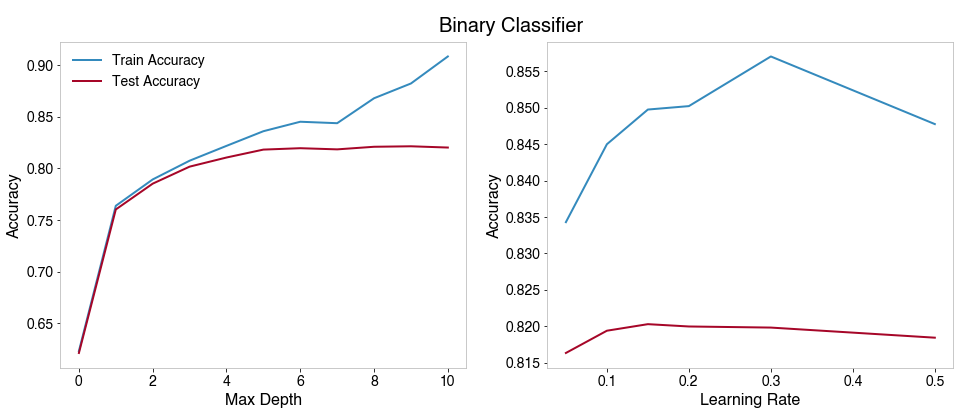

In [57]:
# Formal Joint plot
fig, ax_enum = plt.subplots(1,2, figsize=(16,6))
plt.sca(ax_enum[0])
plt.plot(depths, depth_scores_train, label="Train Accuracy")
plt.plot(depths, depth_scores_test, label="Test Accuracy")
plt.legend(frameon=False,fontsize=14)
plt.ylabel("Accuracy",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)
plt.tick_params(labelsize=14)

plt.sca(ax_enum[1])
plt.plot(eta_values, eta_scores_train, label="Train Accuracy")
plt.plot(eta_values, eta_scores_test, label="Test Accuracy")
plt.ylabel("Accuracy",fontsize=16)
plt.xlabel("Learning Rate",fontsize=16)
plt.tick_params(labelsize=14)

_= plt.annotate("Binary Classifier",xy=(.53,0.96), xycoords="figure fraction", ha="center", va="top", fontsize=20)
plt.savefig(saveDir+"binary_HP_optimization", bbox_inches="tight")

For the binary classifier, the best parameters are: depth = 6, eta = 0.15

### Mutli Classifier

In [58]:
hit_x_train = X_train_hitonly[all_feature_cols]
hit_x_test = X_test_hitonly[all_feature_cols]

hitclass_bdt_param={}
hitclass_bdt_param['learning_rate']      = 0.14 # learning rate
hitclass_bdt_param['subsample']        = 1.0 # fraction of events to train tree on
hitclass_bdt_param['colsample_bytree'] = 1.0 # fraction of features to train tree on
hitclass_bdt_param['objective']   = "multi:softmax"
hitclass_bdt_param['n_estimators']   = 200 
hitclass_bdt_param['feature_names'] = all_feature_cols

# Learning task parameters
hitclass_task_param={}
hitclass_task_param['eval_metric'] = ['mlogloss', 'merror']           # evaluation metric for cross validation
hitclass_task_param['early_stopping_rounds'] = 30
hitclass_task_param['eval_set'] = [(hit_x_train,y_train_hitonly), (hit_x_test,y_test_hitonly)]


depth_scores_train=[]
depth_scores_test=[]
depths = [1, 2, 3, 4, 5, 6]


for depth in depths:
    iparams={}
    hitclass_bdt_param["max_depth"] = depth
    i_opt_bdt =   xgb.XGBClassifier(**hitclass_bdt_param)
    i_opt_bdt.fit(hit_x_train, y_train_hitonly, verbose=False, **hitclass_task_param)
    
    depth_scores_train.append(i_opt_bdt.score(hit_x_train,y_train_hitonly))
    depth_scores_test.append(i_opt_bdt.score(hit_x_test,y_test_hitonly))
    print("Depth {0} completed. Accuracy - Train {1}, Test {2}".format(
        depth,
        depth_scores_train[-1],
        depth_scores_test[-1]
    ))


Depth 1 completed. Accuracy - Train 0.8552940588617398, Test 0.847482797881293
Depth 2 completed. Accuracy - Train 0.8783290860940389, Test 0.8650561853373595
Depth 3 completed. Accuracy - Train 0.8888222655274072, Test 0.8666402653333993
Depth 4 completed. Accuracy - Train 0.892220056962974, Test 0.8655512103361219
Depth 5 completed. Accuracy - Train 0.897416679158547, Test 0.8663927528340181
Depth 6 completed. Accuracy - Train 0.9057612551841303, Test 0.8655512103361219


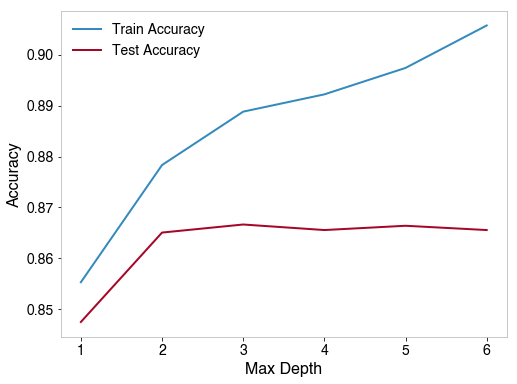

In [59]:
plt.figure(figsize=(8,6))
plt.plot(depths, depth_scores_train, label="Train Accuracy")
plt.plot(depths, depth_scores_test, label="Test Accuracy")
plt.legend(frameon=False,fontsize=14)
plt.ylabel("Accuracy",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)
plt.tick_params(labelsize=14)
plt.savefig(saveDir+"multi_max_depth_optimization", bbox_inches="tight")

In [60]:
hitclass_bdt_param['max_depth']   = 3


eta_scores_train=[]
eta_scores_test=[]
eta_values = [0.05, 0.1, 0.15, 0.2, 0.3, 0.5]


for eta in eta_values:
    iparams={}
    hitclass_bdt_param["learning_rate"] = eta
    i_opt_bdt =   xgb.XGBClassifier(**hitclass_bdt_param)
    i_opt_bdt.fit(hit_x_train, y_train_hitonly, verbose=False, **hitclass_task_param)
    
    eta_scores_train.append(i_opt_bdt.score(hit_x_train,y_train_hitonly))
    eta_scores_test.append(i_opt_bdt.score(hit_x_test,y_test_hitonly))
    print("Learning rate {0} completed. Accuracy - Train {1}, Test {2}".format(
        eta,
        eta_scores_train[-1],
        eta_scores_test[-1]
    ))

Learning rate 0.05 completed. Accuracy - Train 0.8768300604607006, Test 0.8620860353447849
Learning rate 0.1 completed. Accuracy - Train 0.8858741817818419, Test 0.8670362853324093
Learning rate 0.15 completed. Accuracy - Train 0.8879728176685154, Test 0.8674323053314192
Learning rate 0.2 completed. Accuracy - Train 0.8921700894418628, Test 0.8662442453343894
Learning rate 0.3 completed. Accuracy - Train 0.8905211612451907, Test 0.8666897678332756
Learning rate 0.5 completed. Accuracy - Train 0.8873732074151801, Test 0.8647591703381021


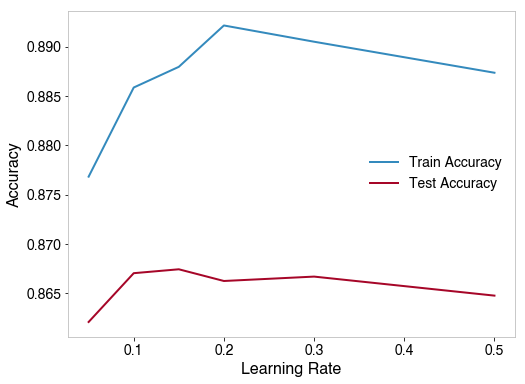

In [61]:
plt.figure(figsize=(8,6))
plt.plot(eta_values, eta_scores_train, label="Train Accuracy")
plt.plot(eta_values, eta_scores_test, label="Test Accuracy")
plt.legend(frameon=False,fontsize=14)
plt.ylabel("Accuracy",fontsize=16)
plt.xlabel("Learning Rate",fontsize=16)
plt.tick_params(labelsize=14)
plt.savefig(saveDir+"multi_eta_optimization", bbox_inches="tight")

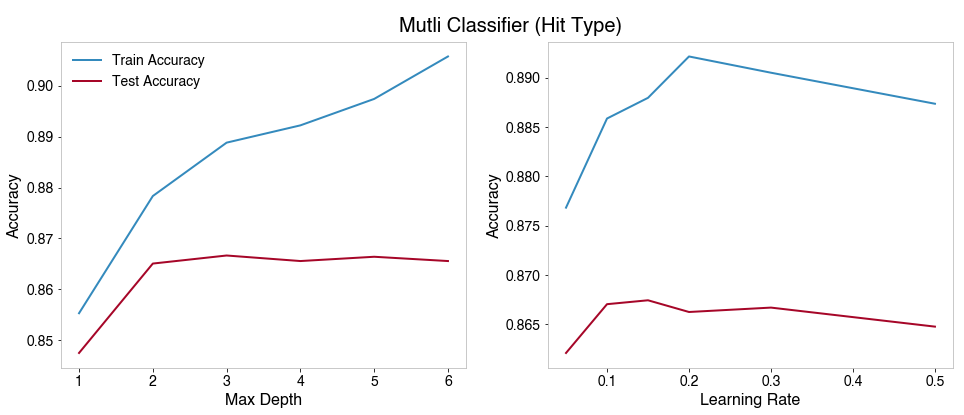

In [62]:
# Formal Joint plot
fig, ax_enum = plt.subplots(1,2, figsize=(16,6))
plt.sca(ax_enum[0])
plt.plot(depths, depth_scores_train, label="Train Accuracy")
plt.plot(depths, depth_scores_test, label="Test Accuracy")
plt.legend(frameon=False,fontsize=14)
plt.ylabel("Accuracy",fontsize=16)
plt.xlabel("Max Depth",fontsize=16)
plt.tick_params(labelsize=14)

plt.sca(ax_enum[1])
plt.plot(eta_values, eta_scores_train, label="Train Accuracy")
plt.plot(eta_values, eta_scores_test, label="Test Accuracy")
plt.ylabel("Accuracy",fontsize=16)
plt.xlabel("Learning Rate",fontsize=16)
plt.tick_params(labelsize=14)

_= plt.annotate("Mutli Classifier (Hit Type)",xy=(.53,0.96), xycoords="figure fraction", ha="center", va="top", fontsize=20)
plt.savefig(saveDir+"multi_HP_optimization", bbox_inches="tight")

Best parameters are: depth = 3, rate = 0.15. Shallower here than on the binary classifier (a little simpler problem, so this is sensible).

Train this model and evaluate it

In [63]:
default_bdt_param={}
default_bdt_param['learning_rate']      = 0.15 # learning rate
default_bdt_param['subsample']        = 1.0 # fraction of events to train tree on
default_bdt_param['colsample_bytree'] = 1.0 # fraction of features to train tree on
default_bdt_param['n_estimators']   = 200 
default_bdt_param['feature_names'] = all_feature_cols

# Learning task parameters
binary_task_param={}
binary_task_param['eval_metric'] = ['logloss', 'error']           # evaluation metric for cross validation
binary_task_param['early_stopping_rounds'] = 30
binary_task_param['eval_set'] = [(final_X_train,binary_y_train), (final_X_test,binary_y_test)]

binary_bdt_param = default_bdt_param.copy()
binary_bdt_param["max_depth"] = 6


final_binary =   xgb.XGBClassifier(**binary_bdt_param)
final_binary.fit(final_X_train, binary_y_train, verbose=False, **binary_task_param)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.15,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)

In [64]:
multiclass_bdt_param = default_bdt_param.copy()
multiclass_bdt_param['max_depth']   = 3

# Learning task parameters
multiclass_task_param={}
multiclass_task_param['eval_metric'] = ['mlogloss', 'merror']           # evaluation metric for cross validation
multiclass_task_param['early_stopping_rounds'] = 30
multiclass_task_param['eval_set'] = [(hit_x_train,y_train_hitonly), (hit_x_test,y_test_hitonly)]

final_multiclass =   xgb.XGBClassifier(**multiclass_bdt_param)
final_multiclass.fit(hit_x_train, y_train_hitonly, verbose=False, **multiclass_task_param)

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0,
              feature_names=['launch_speed', 'launch_angle', 'spray_angle',
                             '1b_park_factor', '2b_park_factor',
                             '3b_park_factor', 'hr_park_factor',
                             'sprint_speed'],
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.15,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints=None, n_estimators=200, n_jobs=0,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1.0,
              tree_method=None, validate_parameters=False, verbosity=None)

In [65]:
evaluated_df = final_X_test.copy()
evaluated_df["binary_prob"] = final_binary.predict_proba(final_X_test)[:,1]
evaluated_df["multiclass_decision"] = final_multiclass.predict(final_X_test)

Check where the best probability threshold is for the binary classifier (should be ~0.5)

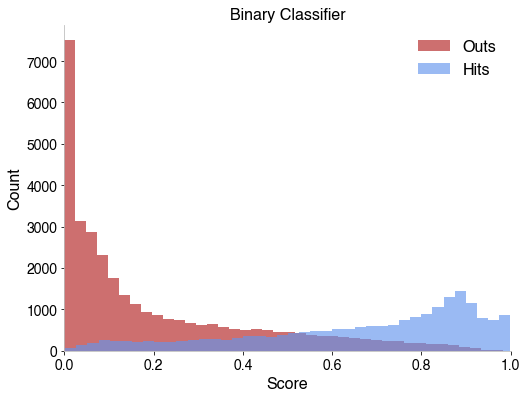

In [66]:
plt.figure(figsize=(8,6))
plt.hist(evaluated_df[final_y_test == 1]["binary_prob"], bins=40, color="firebrick", alpha=0.65, label="Outs")
plt.hist(evaluated_df[final_y_test != 1]["binary_prob"], bins=40, color="cornflowerblue", alpha=0.65, label="Hits")
plt.xlabel("Score",fontsize=16)
plt.ylabel("Count",fontsize=16)
sns.despine()
plt.title("Binary Classifier",fontsize=16)
plt.tick_params(labelsize=14)
plt.legend(frameon=False, fontsize=16)
plt.xlim(left=0,right=1.0)

plt.savefig(saveDir+"binary_probability")

In [67]:
from sklearn.metrics import accuracy_score
cuts = np.arange(0, 1.0, step=.05)
evaluations = []
for score_cut in cuts:
    evaluated_df["final_decision"] =  evaluated_df.apply(lambda row: row["multiclass_decision"] if row["binary_prob"] > score_cut else 1, axis=1)
    evaluations.append(accuracy_score( final_y_test , evaluated_df["final_decision"]))

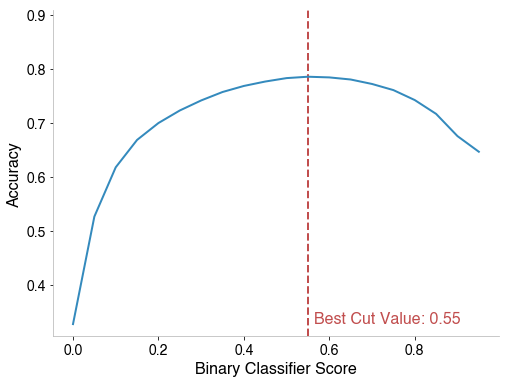

In [68]:
plt.figure(figsize=(8,6))
plt.plot(cuts, evaluations)
best_val = cuts[np.argmax(evaluations)]
ylims= plt.gca().get_ylim()
plt.vlines(best_val, ymin=ylims[0], ymax=ylims[1]+.1, color="Firebrick",linestyle="--",alpha=0.8)
plt.ylim(ylims[0],ylims[1]+.1)
plt.annotate("Best Cut Value: {0}".format(best_val), xy=(best_val+.015, 0.33), ha="left", fontsize=16, color="firebrick",alpha=0.8)
plt.xlabel("Binary Classifier Score", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.tick_params(labelsize=14)
sns.despine()
plt.savefig(saveDir+"binary_probability_accuracy", bbox_inches="tight")

Best cut value is 0.55, so we'll use that when making the final decisions. First make a finalized version of these plots...

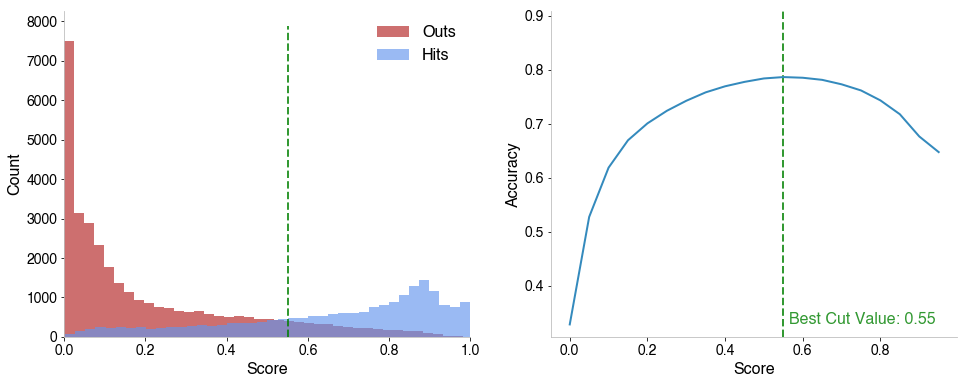

In [69]:
fig, ax_enum = plt.subplots(1,2, figsize=(16,6))
plt.sca(ax_enum[0])
plt.hist(evaluated_df[final_y_test == 1]["binary_prob"], bins=40, color="firebrick", alpha=0.65, label="Outs")
plt.hist(evaluated_df[final_y_test != 1]["binary_prob"], bins=40, color="cornflowerblue", alpha=0.65, label="Hits")
plt.xlim(left=0, right=1)
plt.xlabel("Score",fontsize=16)
plt.ylabel("Count",fontsize=16)
plt.legend(frameon=False, fontsize=16)
ylims= plt.gca().get_ylim()
plt.vlines(best_val, ymin=ylims[0], ymax=ylims[1]+.1, color="green",linestyle="--",alpha=0.8)
sns.despine()
plt.tick_params(labelsize=14)

plt.sca(ax_enum[1])
plt.plot(cuts, evaluations)
best_val = cuts[np.argmax(evaluations)]
ylims= plt.gca().get_ylim()
plt.vlines(best_val, ymin=ylims[0], ymax=ylims[1]+.1, color="green",linestyle="--",alpha=0.8)
plt.ylim(ylims[0],ylims[1]+.1)
plt.annotate("Best Cut Value: {0}".format(best_val), xy=(best_val+.015, 0.33), ha="left", fontsize=16, color="green",alpha=0.8)
plt.xlabel("Score", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.tick_params(labelsize=14)
sns.despine()
plt.savefig(saveDir+"binary_prob_cuts", bbox_inches="tight")

### Final evaluation of stacked model

In [70]:
evaluated_df["final_decision"] =  evaluated_df.apply(lambda row: row["multiclass_decision"] if row["binary_prob"] > 0.55 else 1, axis=1)

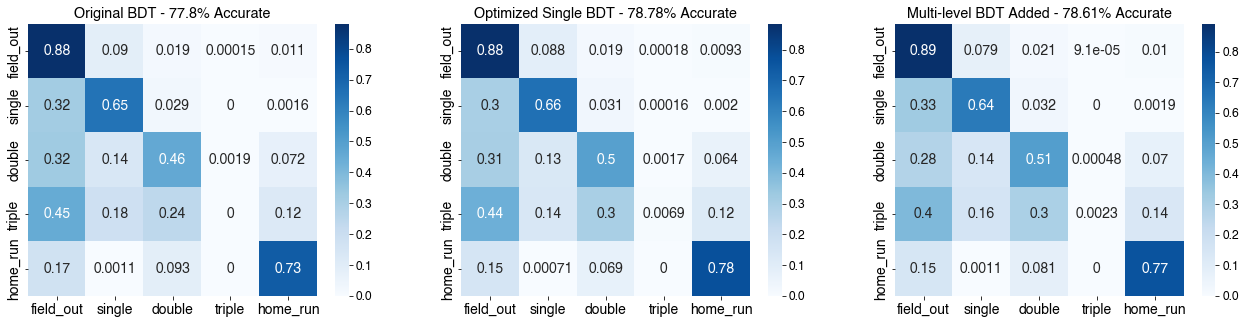

In [71]:
fig, ax_enum = plt.subplots(1,3, figsize=(22,5))
plt.sca(ax_enum[0])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(original_bdt.predict(X_test[original_features])), classnames=targets)
plt.title("Original BDT - {0}% Accurate".format(round(100*original_bdt.score(X_test[original_features], y_test),2)))
plt.sca(ax_enum[1])
conf_matrix(le.inverse_transform(y_test), le.inverse_transform(final_bdt.predict(X_test[all_feature_cols])), classnames=targets)
_=plt.title("Optimized Single BDT - {0}% Accurate".format(round(100*final_bdt.score(X_test[all_feature_cols], y_test),2)))
plt.sca(ax_enum[2])
conf_matrix(le.inverse_transform(final_y_test), le.inverse_transform(evaluated_df["final_decision"].astype(int)), classnames=targets)
_=plt.title("Multi-level BDT Added - {0}% Accurate".format(round(100*accuracy_score(final_y_test , evaluated_df["final_decision"]),2)))
plt.savefig(saveDir+"confusion_multi_level", bbox_inches="tight")

As expected, multilevel model does slightly worse. Better in classifying outs at the sacrifice of singles.